<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/species_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# basemapのインストールに必要なライブラリを取得
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     / 133.1 MB 431 kB/s
     |████████████████████████████████| 6.6 MB 6.7 MB/s 
     |████████████████████████████████| 219 kB 53.2 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759602 sha256=4032a4c71f6524a5d7b0a284aa4ffee39358ca29e852d39e6df59bad8d40d3e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-j

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import fetch_species_distributions

# ノドチャナマケモノ(Bradypus variegatus), コメネズミ(Microryzomys minutus)
data = fetch_species_distributions()
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

In [7]:
species.shape

(1624,)

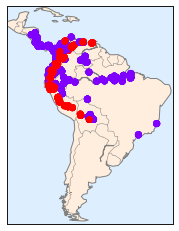

In [6]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)
# 海外線を描画
m = Basemap(projection='cyl',
            resolution='c',
            llcrnrlat=ygrid.min(),
            urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(),
            urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)
# speciesの生息位置をプロット
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, c=species, cmap='rainbow', latlon=True)

プロットでは点が重なり合ってしまうため、正確な分布を表現できない

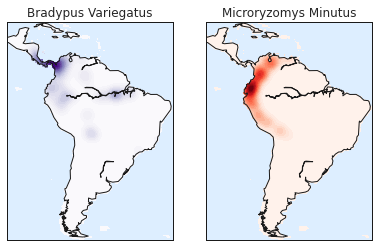

In [28]:
from sklearn.neighbors import KernelDensity

X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
  axi.set_title(species_names[i])

  m = Basemap(projection='cyl', 
              llcrnrlat=Y.min(),
              urcrnrlat=Y.max(),
              llcrnrlon=X.min(),
              urcrnrlon=X.max(),
              resolution='c',
              ax=axi)
  m.drawmapboundary(fill_color='#DDEEFF')
  # m.fillcontinents(color='#FFEEDD')
  m.drawcoastlines()
  m.drawcounties(color='gray')

  # 分布の球面上核密度推定
  kde = KernelDensity(bandwidth=0.03, metric='haversine')
  kde.fit(np.radians(latlon[species == i]))

  # 陸上のみを評価する(-9999は海上を示す)
  Z = np.full(land_mask.shape[0], -9999.0)
  Z[land_mask] = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)

  levels = np.linspace(0, Z.max(), 25)
  axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])